# Anomaly Detection

### Introduction to anomaly detection

*   Also known as Outlier Analysis. An **outlier(anomaly)** is a data object that deviates significantly from the rest of the objects.    

  <img src="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9780123814791/files/images/F000125f12-01-9780123814791.jpg">

  Fig 1. The objects in region R are outliers

*   Types of outliers
 *  **Global outlier** (point anomalies) - an outlier deviates significantly from the rest of the data set
 *  **Contextual outlier** - an outlier depends on the context—the date, the location, and possibly some other factors
 *  **Collective outlier** - a subset of objects as a whole deviate significantly from the entire data set

 <img src="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9780123814791/files/images/F000125f12-02-9780123814791.jpg">

 Fig 2. The black objects form a collective outlier.

*   Challenges of anomaly detection
 *  Modeling normal objects and outliers effectively
 *  Application-specific outlier detection
 *  Handling noise in outlier detection
 *  Understandability

*   Model development and evaluation (Goldstein & Uchida, 2016):

 *  **Supervised anomaly detection** uses **a fully labeled dataset** for training.
 *  **Semi-supervised anomaly detection** uses an **anomaly-free training dataset**. Afterwards, deviations in the test data from that normal model are used to detect anomalies.
 *  **Unsupervised anomaly detection algorithms** use only **intrinsic information** of the data in order to detect instances deviating from the majority of the data. ***“Although unsupervised anomaly detection does not utilize any label information in practice, they are needed for evaluation and comparison. When new algorithms are proposed, it is common practice that an available public classification dataset is modified and the method is compared with the most known algorithms （(Goldstein & Uchida, 2016， p17)”***

* Review from 290 articles published from 2000 to 2020 (Nassif et al., 2021):
  * 29 distinct machine learning models
  * 22 datasets used, e.g., video anomaly detection, intrusion detection, hyperspectral imagery, medical application etc.
  * Gaussian model appeared 2 times out of 290 articles
  * unsupervised anomaly detection has been adopted more than other classification anomaly detection systems

###   Example: Credit Card Fraud Detection


*   Data can be downloaded from Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
*   **Context**
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

*  **Content**
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

  It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

  Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.







In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Set the working directory, can be removed/replaced with your working directory
!pwd
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/INFT 3046/Drop-ins/data')
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/INFT 3046/Drop-ins/data


In [3]:
# import the modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# Setup the environment
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) # This will help keep the notebook clean from unnecessary warnings

In [ ]:
'''
# for unzip the data, uncomment if run the first time
import zipfile
with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall("data")
'''

In [5]:
# import data to a dataframe
df_full = pd.read_csv(os.getcwd() + "/creditcard.csv")

In [6]:
# return the columns
print(df_full.columns.values)

['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount' 'Class']


In [8]:
df_full.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Subsampling for demonstration purposes. Running the script on the whole dataset takes a while.

In [ ]:
df_sample = df_full.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.05))

#### Separate feature set and label set

In [10]:
# Separating features from the labels
# 'Class' is the target variable indicating fraud or no fraud, so it is excluded from the feature set
data_features = df_sample.drop(columns=['Class'])

In [11]:
# labels
# The target variable 'Class' is stored separately for model training or evaluation
data_label = df_sample['Class']
data_label.value_counts()

,count
Class,
0,14216
1,25


#### Normalise the features

In [12]:
# function to normalise the features using z-score normalisation
def featureNormalise(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, ddof=1, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm

In [13]:
normalised_features = featureNormalise(data_features)

#### Inspect the feature space using tSNE and visualisation

Comparing to PCA, tSNE is capable of perserving the local structure of data, thus more suitable for visualising high-dimensional dzata.



In [14]:
# t-Distributed Stochastic Neighbor Embedding (t-SNE)
# use tSNE to visualize high-dimensional data: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Use t-SNE for dimensionality reduction: it helps visualize high-dimensional data by preserving local relationships,
# making it easier to identify clusters and patterns in a visual, two or three-dimensional space.
# reduce the dimension to 3 in the embedded space
tSNE_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=10).fit_transform(normalised_features)

print('t-SNE done!')

t-SNE done!


In [15]:
# append the tSNE embedded space to the sample dataframe
df_sample['tsne-one'] = tSNE_embedded[:,0]
df_sample['tsne-two'] = tSNE_embedded[:,1]
df_sample['tsne-three'] = tSNE_embedded[:,2]

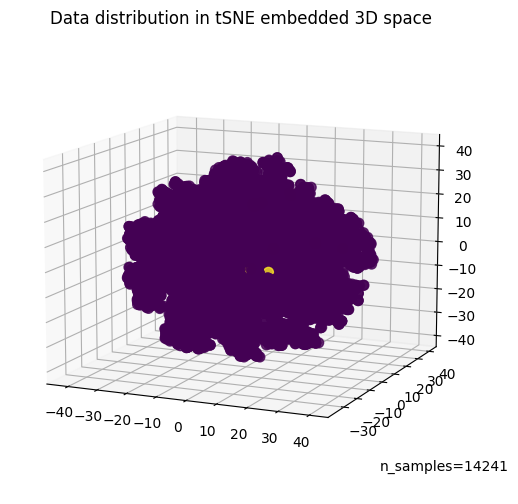

In [16]:
# visualise the data after tSNE. Code referenced from: https://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html#sphx-glr-auto-examples-manifold-plot-swissroll-py
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
fig.add_axes(ax)
ax.scatter(
    df_sample['tsne-one'], df_sample['tsne-two'], df_sample['tsne-three'], c=df_sample['Class'], s=50, alpha=0.8
)
ax.set_title('Data distribution in tSNE embedded 3D space')
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s='n_samples='+str(len(df_sample)), transform=ax.transAxes)

fig, axs = plt.subplots(figsize=(8, 8), nrows=2)
axs[0].scatter(df_sample['tsne-one'], df_sample['tsne-two'], c=df_sample['Class'])
axs[0].set_title('t-SNE Embedding of Data - Embedding 1 vs Embedding 2')
axs[1].scatter(df_sample['tsne-one'], df_sample['tsne-three'], c=df_sample['Class'])
_ = axs[1].set_title('t-SNE Embedding of Data - Embedding 1 vs Embedding 3')

#### Inspect the feature space using PCA and visualisation

In [17]:
# svd factorisation: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html,
# A(input) = USV(h), s contains the singular values of A, u are the eigenvectors of AAh, Vh are the eigenvectors of AhA
def pca(X):
    # Calculate the covariance matrix of the transposed input data X
    Sigma = np.dot(X.T, X) / X.shape[0]
    # Perform SVD on the covariance matrix
    # U: Matrix of eigenvectors, which are the principal components
    # S: Vector of singular values, indicating the variance captured by each principal component
    # _: The right singular vectors (not used here)
    U, S, _ = np.linalg.svd(Sigma)
    return U, S

# function to convert original data to principal components
def projectData(X, U, K):
    Z = np.dot(X, U[:, :K])
    return Z

In [18]:
# fit the model on normalised features
U, S = pca(normalised_features)

In [19]:
# reduce to 3 principal components
n_pca = 3
pca_reduced = projectData(normalised_features, U, n_pca)
print("PCA done!")

PCA done!


In [20]:
# append the pca reduced feature space to the sample dataframe
df_sample['pca-one'] = pca_reduced[:,0]
df_sample['pca-two'] = pca_reduced[:,1]
df_sample['pca-three'] = pca_reduced[:,2]

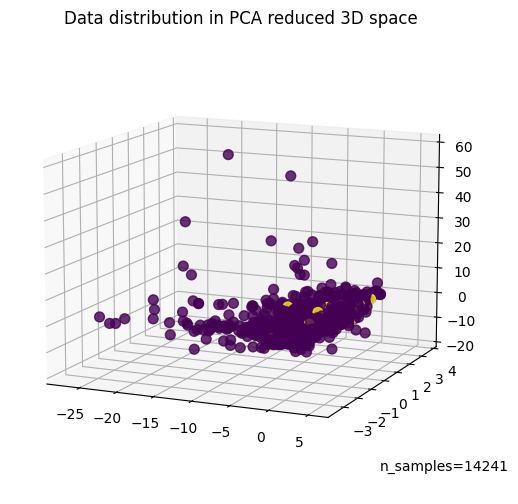

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
fig.add_axes(ax)
ax.scatter(
    df_sample['pca-one'], df_sample['pca-two'], df_sample['pca-three'], c=df_sample['Class'], s=50, alpha=0.8
)
ax.set_title('Data distribution in PCA reduced 3D space')
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s='n_samples='+str(len(df_sample)), transform=ax.transAxes)

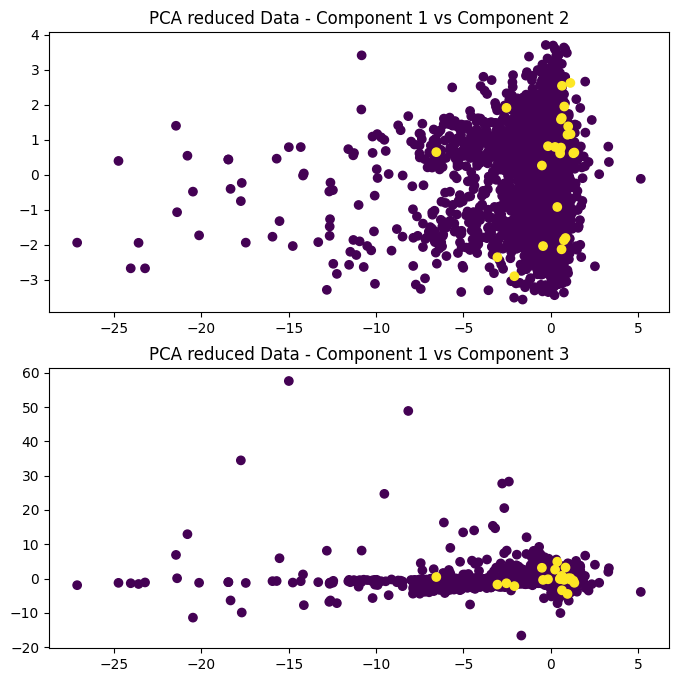

In [22]:
fig, axs = plt.subplots(figsize=(8, 8), nrows=2)
axs[0].scatter(df_sample['pca-one'], df_sample['pca-two'], c=df_sample['Class'])
axs[0].set_title('PCA reduced Data - Component 1 vs Component 2')
axs[1].scatter(df_sample['pca-one'], df_sample['pca-three'], c=df_sample['Class'])
_ = axs[1].set_title('PCA reduced Data - Component 1 vs Component 3')

#### Estimating Gaussian Parameters - mean and variance

In [ ]:
# function to estimate Gaussian parameters: mean, variance
def estimateGaussian(X):
    """
    Estimates the parameters of a Gaussian distribution using the data.

    Args:
    X (ndarray): Input data matrix where each row represents a sample and each column a feature.

    Returns:
    mu (ndarray): Vector of means for each feature.
    sigma2 (ndarray): Vector of variances for each feature.
    """
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

#### Calculate the Gaussian parameters

In [ ]:
# Calculate the Gaussian parameters for the normalized features
mu, sigma2 = estimateGaussian(normalised_features)
print(mu, sigma2)

#### Construct the Gaussian distribution

In [ ]:
# apply scipy.stats.multivariate_normal function to generate a multivariate normal random variable based on the Gassuain parameters
# refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html for function details
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))

#### Fit data to the model and estimate the probability for each data point

In [ ]:
# apply the probability density function: pdf(x, mean=None, cov=1, allow_singular=False)
probs = distribution.pdf(normalised_features)
min(probs)

0.0

In [ ]:
max(probs)

7.475769631491134e-14

#### Without labels - Select the best threshold using grid search and visual inspection

In [ ]:
# function to walk through a range of epsilon values and visualise the outliers
def selectThresholdGS(p):
  # define a value list to perform the grid search
  epsilons = [np.min(p), np.max(p)*1e-06, np.max(p)*1e-05, np.max(p)*1e-04, np.max(p)*1e-03, np.max(p)*1e-02, np.max(p)*1e-01, np.max(p)]
  for epsilon in epsilons:
    # get the normalies and abnormalies from fitted model
    predictions = (p < epsilon).astype(int)
    # plot the 3D graph to fit the outliers
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.add_axes(ax)
    ax.scatter(
        df_sample['tsne-one'], df_sample['tsne-two'], df_sample['tsne-three'], c=predictions, s=50, alpha=0.8)
    ax.set_title('Data distribution in tSNE embedded 3D space after fitting')
    ax.view_init(azim=-66, elev=12)
    _ = ax.text2D(0.8, 0.05, s='epsilon= '+str(epsilon)+' n_samples='+str(len(df_sample)), transform=ax.transAxes)

#### Apply the threshold selection procedure

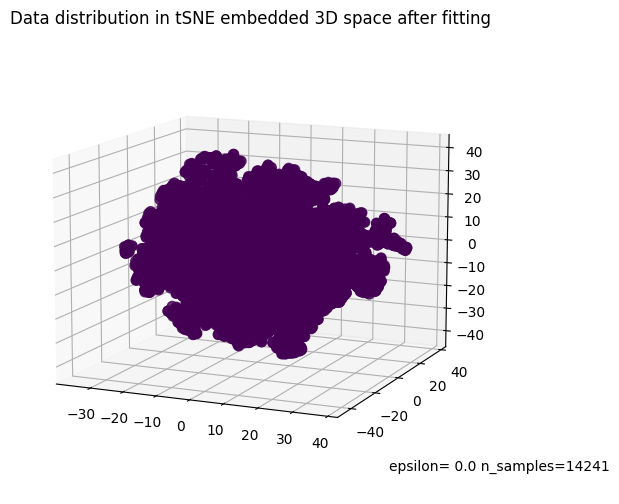

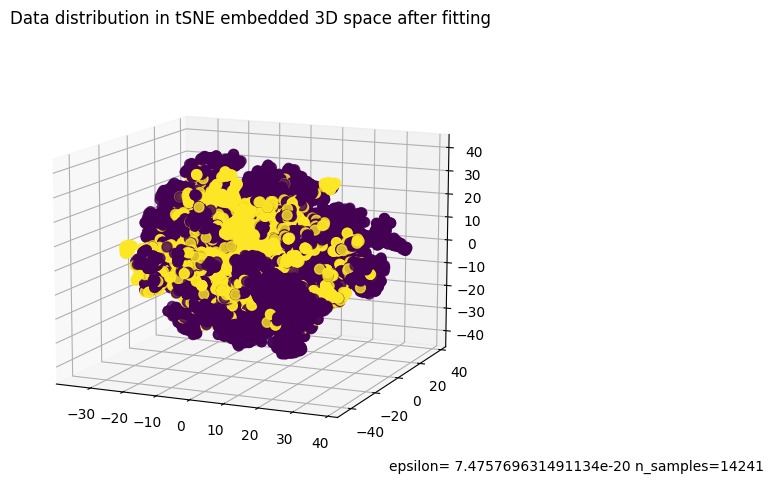

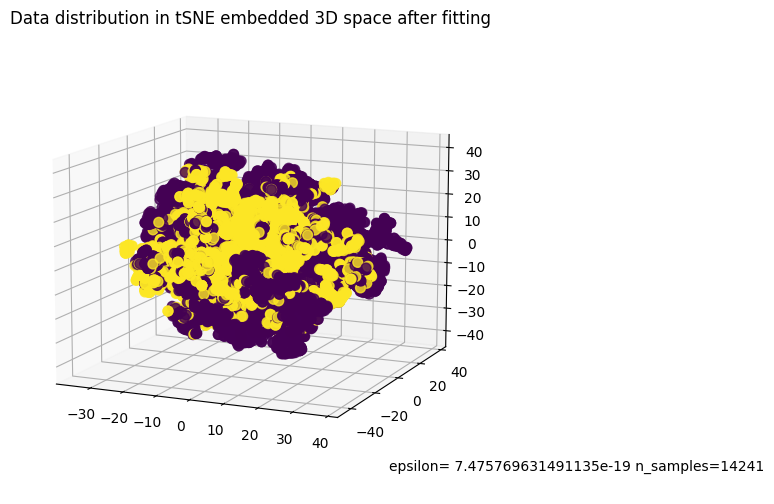

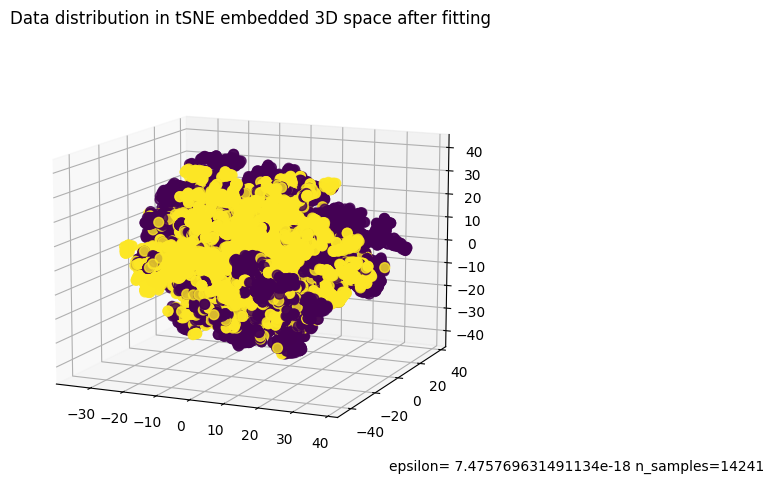

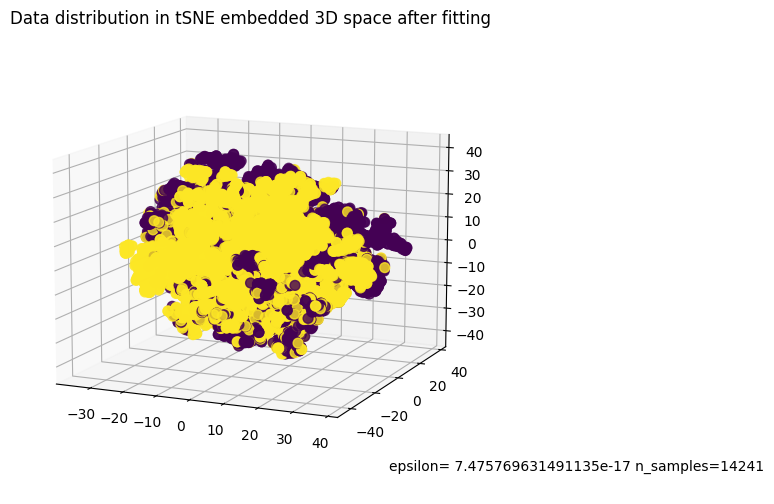

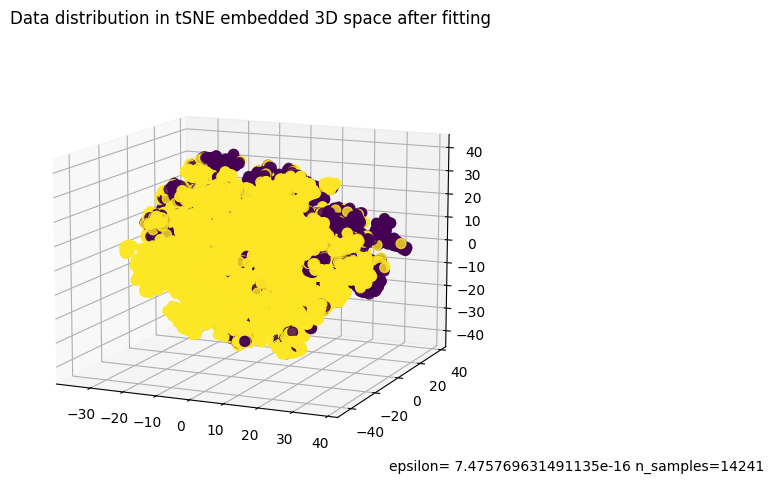

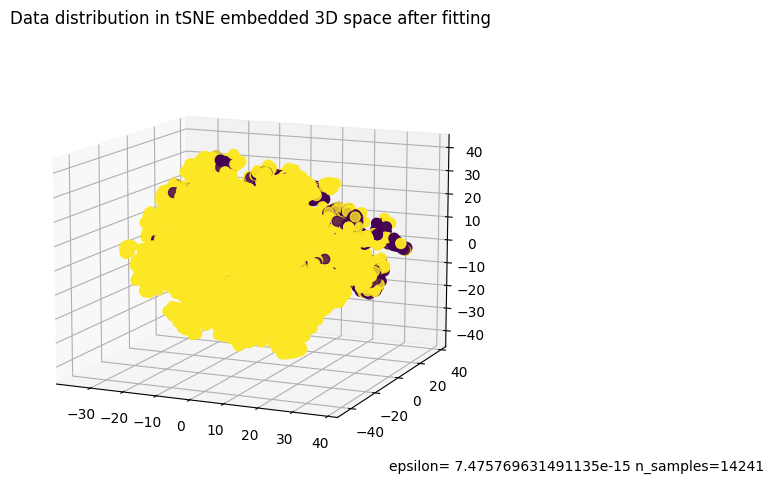

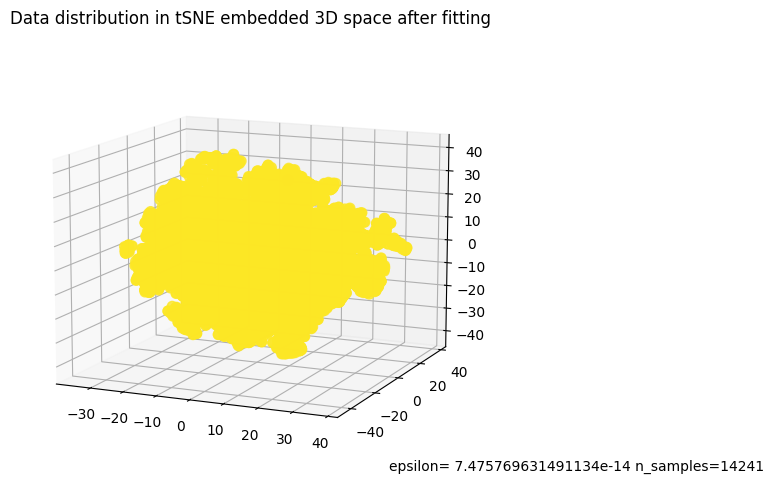

In [ ]:
selectThresholdGS(probs)

### Anomaly Detection

In [ ]:
# import the modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
from scipy.io import loadmat
from scipy.stats import multivariate_normal

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

#### Load the dataset `ex8data1.mat`

In [ ]:
data = loadmat("ex8data1.mat")
X = data["X"]
print(X.shape)
Xval, yval = data["Xval"], data["yval"].ravel()
print(Xval.shape, yval.shape)

(307, 2)
(307, 2) (307,)


In [ ]:
# original dataset, splitted into X and Xval
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.294

In [ ]:
# X for estimating the parameters - mean variance
X

array([[13.04681517, 14.74115241],
       [13.40852019, 13.7632696 ],
       [14.19591481, 15.85318113],
       [14.91470077, 16.17425987],
       [13.57669961, 14.04284944],
       [13.92240251, 13.40646894],
       [12.82213164, 14.22318782],
       [15.67636615, 15.89169137],
       [16.16287532, 16.20299807],
       [12.66645095, 14.89908374],
       [13.98454962, 12.95800822],
       [14.06146043, 14.54908874],
       [13.38988671, 15.56202142],
       [13.39350475, 15.62698794],
       [13.97900926, 13.28061494],
       [14.16791259, 14.46583829],
       [13.96176145, 14.75182421],
       [14.45899735, 15.07018563],
       [14.58476372, 15.82743424],
       [12.07427074, 13.0671109 ],
       [13.5491294 , 15.53827677],
       [13.98625042, 14.78776304],
       [14.96991942, 16.51830493],
       [14.25576597, 15.29427277],
       [15.33425   , 16.12469989],
       [15.6350487 , 16.49094477],
       [13.62081292, 15.45947525],
       [14.81548485, 15.33956527],
       [14.59318973,

In [ ]:
# Xval for testing the parameters and evaluating the performance
Xval

array([[15.79025979, 14.9210243 ],
       [13.63961877, 15.32995521],
       [14.86589943, 16.47386514],
       [13.58467605, 13.98930611],
       [13.46404167, 15.63533011],
       [12.94888838, 16.14006828],
       [15.31084155, 15.17480137],
       [13.89795241, 15.43169469],
       [11.92096525, 14.30579937],
       [14.85934119, 14.90066474],
       [13.63501268, 14.5620583 ],
       [15.75981741, 15.13340409],
       [15.221965  , 14.18491044],
       [12.10564111, 13.42653822],
       [14.80848889, 13.87075725],
       [15.36135887, 15.99014917],
       [12.72914442, 15.8265107 ],
       [15.38533789, 15.21036416],
       [13.81810534, 14.29933915],
       [15.3788488 , 15.90228514],
       [14.11232153, 15.31616729],
       [12.82415241, 13.6971992 ],
       [14.58354683, 14.99675181],
       [14.2948367 , 15.84651796],
       [13.5112881 , 15.5909427 ],
       [13.71433284, 15.35484382],
       [12.85788467, 14.00239134],
       [14.56998008, 14.22432035],
       [15.59049569,

#### Visualise the dataset with the scatter plot

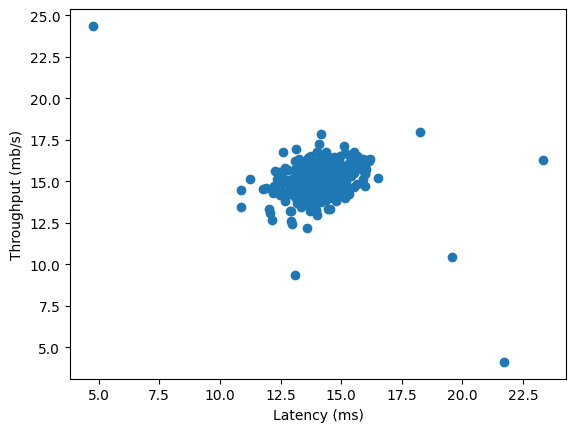

In [ ]:
# use scatter plot to visualise the data distribution for X
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

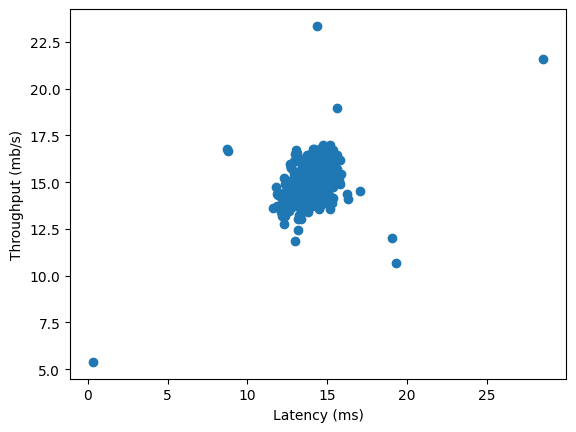

In [ ]:
# use scatter plot to visualise the data distribution for Xval
plt.figure()
plt.scatter(Xval[:, 0], Xval[:, 1])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

#### Estimating Gaussian Parameters - mean and variance

In [ ]:
# function to estimate Gaussian parameters: mean, variance
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

#### Calculate the Gaussian parameters

In [ ]:
mu, sigma2 = estimateGaussian(X)
print(mu, sigma2)

[14.11222578 14.99771051] [1.83263141 1.70974533]


#### Visualise the dataset and the Gaussian anomaly detector

In [ ]:
# function to visualise fitting the Gaussian anomaly detector on the data
def visualiseFit(distribution, X):
    # Defining Grid Limits
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Creating a Meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    X_plot = np.c_[xx.ravel(), yy.ravel()]

    # apply the probability density function to return the probabilities of objects
    y_plot = distribution.pdf(X_plot).reshape(xx.shape)

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.contour(xx, yy, y_plot, levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
    plt.show()

#### Construct the Gaussian distribution

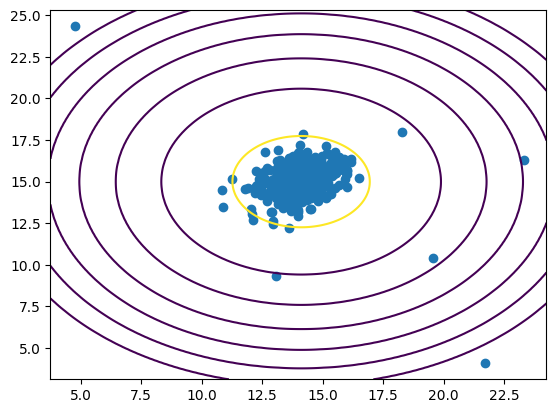

In [ ]:
# apply scipy.stats.multivariate_normal function to generate a multivariate normal random variable based on the Gassuain parameters
# refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html for function details
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
visualiseFit(distribution, X)

#### Select the best threshold returning the highest F1 score

In [ ]:
# function to select the best epsilon (threshold) for determining anomalies
def selectThreshold(yval, pval):
    # Initialize the best F1 score to the lowest possible value
    bestF1 = -np.inf
    step = (np.max(pval) - np.min(pval)) / 1000

    # Iterate through potential epsilon values to find the best threshold
    for epsilon in np.arange(np.min(pval),
                             np.max(pval) + step, step):
        predictions = (pval < epsilon).astype(int)       # Generate predictions for this threshold
        tp = np.sum(np.multiply(predictions, yval))      # Calculate true positives
        fp = np.sum(np.multiply(predictions, 1 - yval))  # Calculate false positives
        fn = np.sum(np.multiply(1 - predictions, yval))  # Calculate false negatives
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2 * precision * recall / (precision + recall)
        # If this F1 score is better, update the best scores and threshold
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

#### Apply the threshold selection procedure

In [ ]:
# apply the probability density function: pdf(x, mean=None, cov=1, allow_singular=False)
pval = distribution.pdf(Xval)
bestEpsilon, bestF1 = selectThreshold(yval, pval)  # Get the best threshold and F1 score
print(bestEpsilon, bestF1)

8.990852779269493e-05 0.8750000000000001


#### Visualise the dataset and the Gaussian anomaly detector. Outliers need to be indicated.

In [ ]:
def visualiseFitOutliers(distribution, X, outliers):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    y_plot = distribution.pdf(X_plot).reshape(xx.shape)

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(X[outliers, 0], X[outliers, 1], s=100)
    plt.contour(xx, yy, y_plot, levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
    plt.show()

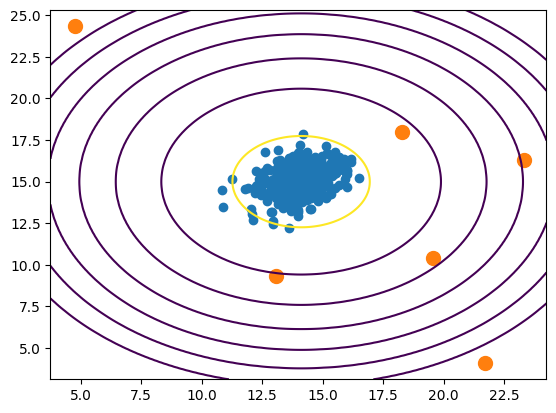

In [ ]:
p = distribution.pdf(X)
outliers = np.where(p < bestEpsilon)[0]
visualiseFitOutliers(distribution, X, outliers)

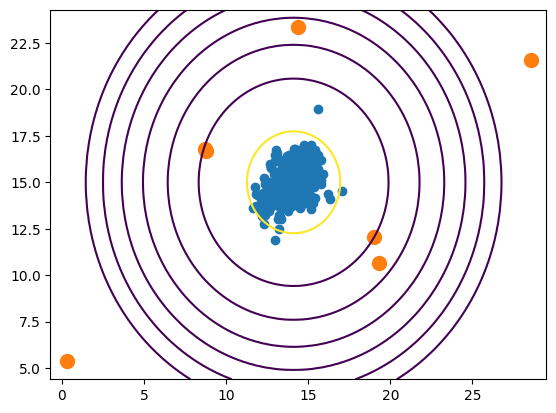

In [ ]:
pval = distribution.pdf(Xval)
outliers = np.where(pval < bestEpsilon)[0]
visualiseFitOutliers(distribution, Xval, outliers)

### Task - Perform anomaly detection on a high-dimensional dataset `ex8data2.mat`

In this exercise, repeat the above process to construct a Gaussian anomaly detector and apply it to the dataset `ex8data2.mat`.

#### Load another dataset `ex8data2.mat`

In [ ]:
data = loadmat("ex8data2.mat")
X = data["X"]
print(X.shape)
Xval, yval = data["Xval"], data["yval"].ravel()
print(Xval.shape, yval.shape)

(1000, 11)
(100, 11) (100,)


#### Construct the Gaussian anomaly detector, select the best threshold and calculate the best F1 score

In [ ]:
# Estimate the Gaussian parameters from the training data
mu, sigma2 = estimateGaussian(X)
# Create a multivariate normal distribution with the estimated parameters
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
# Calculate the probability density function of the training data
p = distribution.pdf(X)

# Calculate the probability density function of the validation data
pval = distribution.pdf(Xval)
# Determine the best threshold epsilon using the F1 score from validation labels
bestEpsilon, bestF1 = selectThreshold(yval, pval)
print(bestEpsilon, bestF1)  # 1.38e-18 0.615385
print(sum(p < bestEpsilon))  # 117

1.3772288907613604e-18 0.6153846153846154
117
